In [1]:
import seaborn as sns
sns.set()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import lsq_linear
from scipy import linalg
from scipy.sparse import diags

# Detecting a resonance far from the absorbtion peak

We will use the Lorentz-Drude model

In [3]:
def format_xticks(x, pos=None):
    """
    The exponential notation for numbers using LaTeX
    """

    if np.isclose(x, 0):
        return "0"

    if x < 0:
        return str(x)

    log10x = np.log10(x)
    exponent = int(np.floor(log10x))
    prefactor = 10. ** (log10x - exponent)

    if np.isclose(prefactor, 1):
        return "$10^{{{:d}}}$".format(exponent)
    else:
        return "${:.0f} \cdot 10^{{{:d}}}$".format(prefactor, exponent)

In [135]:
class SOSpectroscopy:
    
    def __init__(self, *, omega_measurements, n0, omega0, gamma, omega_p1, omega_p2):
        """
        omega0 -- absorption peak
        n0 ** 2 -- high frequency permutivity
        """
        # saving parameters
        self.omega_measurements = omega_measurements[np.newaxis, :]
        self.n0 = n0
        self.omega0 = omega0
        self.gamma = gamma
        self.omega_p1 = omega_p1
        self.omega_p2 = omega_p2
        
        # save permutivies for the first and second material
        self.epsilon1 = self.epsilon(
            omega=self.omega_measurements, 
            n0=self.n0, 
            omega0=self.omega0,
            gamma=self.gamma,
            
            omega_p=self.omega_p1,
        )
        
        self.epsilon2 = self.epsilon(
            omega=self.omega_measurements, 
            n0=self.n0, 
            omega0=self.omega0,
            gamma=self.gamma,
            
            omega_p=self.omega_p2,
        )
        
        # generating time grids
        self.short_half_period = np.pi / np.abs(omega_measurements).max()
        self.short_time = np.linspace(-self.short_half_period, self.short_half_period, 500)[:, np.newaxis]
        
        self.long_period = 4 * np.pi / np.abs(omega_measurements).min()
        self.long_time = np.linspace(-self.long_period, self.long_period, 500)[:, np.newaxis]
    
    def discrimination(self, max_amplitudes):
        """
        Analyze how superoscilating field can help to discriminate two materials
        """
        # aligment of plots
        plotx, ploty = 1, len(max_amplitudes)
        
        # peaked function to be fitted to
        peaked_function = self.peaked_function(self.short_time)
        
        # fit super oscillations to peaked function for short-time window
        ones = np.ones(self.omega_measurements.size)
        
        _, axes = plt.subplots(ncols=len(max_amplitudes), sharey=True, sharex=True)
        
        for ax, max_ampl in zip(axes[::-1], max_amplitudes[::-1]):
            fit_results = lsq_linear(
                np.abs(self.epsilon1) * np.cos(self.omega_measurements * self.short_time),
                peaked_function.reshape(-1),
                bounds=(-max_ampl * ones, max_ampl * ones),
            )
            
            # consistency check
            if not fit_results.success:
                print(fit_results.warning)
        
            if not fit_results.active_mask.any():
                print("At max_ampl = {:.0e} no constraints are activated".format(max_ampl))
    
            field = fit_results.x.reshape(self.omega_measurements.shape)
        
        
            ax.set_title('Max amplitude = {}'.format(format_xticks(max_ampl)))

            time_unit = (2. * self.short_half_period)            
            t = self.short_time 
        
            ax.plot(
                t / time_unit, 
                np.sum(field * np.abs(self.epsilon1) * np.cos(self.omega_measurements * t), axis=1),
                '--',
                label='with lactose',
            )        
            ax.plot(
                t /  time_unit, 
                np.sum(
                    field * np.abs(self.epsilon2) * np.cos(
                        self.omega_measurements * t + np.angle(self.epsilon2) - np.angle(self.epsilon1)
                    ), 
                    axis=1,
                ),
                label='no lactose',
            )
        
            ax.set_xlabel('time, $2\pi / \omega_\max$')
            
        ax.set_ylabel('Electric fields in arbitrary units')

    
    def peaked_function(self, t):
        # Narrow function to approximate to
        return np.exp(-(10 * t / self.short_half_period) ** 2)
    
    @classmethod
    def epsilon(cls, *, omega, n0, omega0, gamma, omega_p):
        """
        Lorentz-Drude electrical permutivity 
        """
        return n0 ** 2 + omega_p ** 2 / (omega0 ** 2 - omega ** 2 - 1j * gamma * omega)

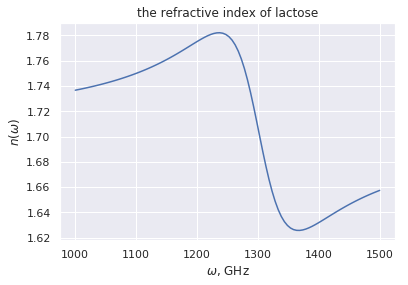

In [136]:
# Fitting to lactose data

# all units are in GHz
omega = 1e3 * np.linspace(1, 1.5, 100)

plt.title('the refractive index of lactose')
plt.plot(
    omega,
    np.sqrt(
        SOSpectroscopy.epsilon(
            omega=omega,
            n0=1.7,
            gamma=130,
            omega0=1300,
            omega_p=300,
        )
    ).real
)

plt.xlabel('$\omega$, GHz')
plt.ylabel('$n(\omega)$')
plt.show()

In [137]:
sos = SOSpectroscopy(
    omega_measurements=np.linspace(400, 800, 5), 
    
    # parameters taken from the fit above
    n0=1.7,
    gamma=130,
    omega0=1300,

    # sample 1: contains lactose
    omega_p1=300,
    
    # sample 2: contains NO lactose
    omega_p2=0,
)

At max_ampl = 5e+03 no constraints are activated


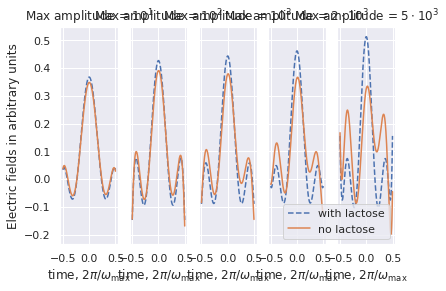

In [138]:
sos.discrimination(max_amplitudes=[1e1, 1e2, 1e3, 0.2e4, 0.5e4])
plt.legend()
plt.show()

In [11]:
def discriminability_time_interval(omega_measurements, tau1, tau2, half_durations):
    
    omega_measurements = omega_measurements[np.newaxis, :]
    
    # time derivative matrix
    num_time_steps = 1000
    diff_t = diags([1., -1.], [1, -1], (num_time_steps, num_time_steps)).toarray()
    
    print(diff_t.shape)
    
    discriminability = []
    
    for half_duration in half_durations:
    
        # generating time grids
        time = np.linspace(-half_duration, half_duration, num_time_steps)[:, np.newaxis]

        # 
        sigma1 = tau1 / (1. + 1j * omega_measurements * tau1)
        sigma2 = tau2 / (1. + 1j * omega_measurements * tau2)
        
        singular_values = linalg.svdvals(
            (sigma1 - sigma2) * np.exp(1j * time * omega_measurements)
        ).max()
        
        discriminability.append(singular_values)
    
    longest_period = 2. * np.pi / np.abs(omega_measurements).min()
    
    plt.semilogx(2 * half_durations / longest_period, discriminability)
    
    plt.xlabel("The Duration of time-window (in units of $2 \pi / \omega_{\min}$)")
    plt.ylabel("Discriminability (arbitrary units)")

(1000, 1000)


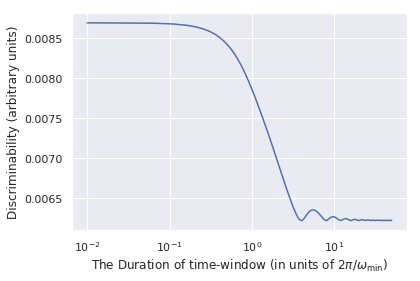

In [12]:
discriminability_time_interval(
        omega_measurements=np.linspace(-80, -40, 5), 
        tau1=0.05, 
        tau2=0.051,
        half_durations=np.linspace(100 * np.pi / 80, 0.01 * np.pi / 40, 1000)
)

plt.show()

In [18]:
def fields_transmitted(omega_measurements, tau1, tau2, half_duration):
    
    omega_measurements = omega_measurements[np.newaxis, :]
    
    # time derivative matrix
    num_time_steps = 1000
    #diff_t = diags([1., -1.], [1, -1], (num_time_steps, num_time_steps)).toarray()
    
    time = np.linspace(-half_duration, half_duration, num_time_steps)[:, np.newaxis]

    # 
    sigma1 = tau1 / (1. + 1j * omega_measurements * tau1)
    R1 = sigma1 * np.exp(1j * time * omega_measurements)
    
    sigma2 = tau2 / (1. + 1j * omega_measurements * tau2)
    R2 = sigma2 * np.exp(1j * time * omega_measurements)
    
    #U, s, Vh = linalg.svd(diff_t.dot(R1 - R2), full_matrices=False)
    U, s, Vh = linalg.svd(R1 - R2, full_matrices=False)
    
    E1_out = R1.dot(Vh[0]).real
    E2_out = R2.dot(Vh[0]).real
        
    print("Signular value {}".format(s[0]))
    
    #print(np.abs(sigma1 / sigma2).max() - 1)
    
    longest_period = 2. * np.pi / np.abs(omega_measurements).min()
        
    plt.plot(time / longest_period, E1_out)
    plt.plot(time / longest_period, E2_out)
    
    #print(np.abs(E1_out / E2_out).max() - 1)
    
    plt.xlabel("time, $t$ (in units of $2 \pi / \omega_{\min}$)")
    plt.ylabel('$E(t)$')

Signular value 0.008695161462099888


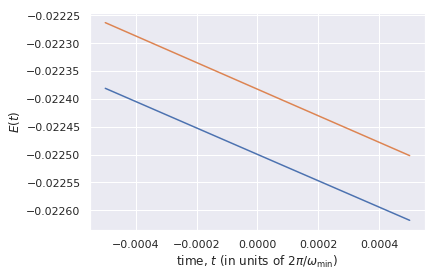

In [19]:
fields_transmitted(
        omega_measurements=np.linspace(-80, -40, 5), 
        tau1=0.05, 
        tau2=0.051,
        half_duration=(0.001 * np.pi / 40)
    )

In [15]:
def plot_resonance(omega, tau1, tau2):
    sigma_1 = tau1 / (1. + 1j * omega * tau1) / np.pi
    
    plt.plot(
        omega, np.real(sigma_1), label='$\\tau_1$'
    )
    
    sigma_2 = tau2 / (1. + 1j * omega * tau2) / np.pi
    
    print(np.real(sigma_1).sum())
    print(np.real(sigma_2).sum())
    
    plt.plot(
        omega, np.real(sigma_2), label='$\\tau_2$'
    )

    plt.legend()
    plt.show()

0.4334035425022968
0.48276721744897255


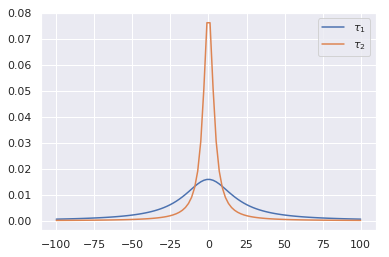

In [16]:
plot_resonance(np.linspace(-100, 100, 100),0.05, 5 * 0.051)